# Segmenting Cardiomyoctye Model Parameters

### *Personal Note*

*The data and analysis included here was part of a project where I evaluated predictions of cardiomyocyte action potential models. The objective here is to separate different hypotheses from a population of models. Additionally, I review some different clustering stratagies. The model features have biophysical and physiological meaning, but I will put a principal component step in as well. The data set here was the resulting output from training multiple independent populations of models using evolutionary algorithms. I hope you find it interesting.*

## Introduction

The cardiac action potential (AP) is the electrical waveform that is conducted through individual cells during a cardiac cycle. Cardiac electrophysiology is a complex system consisting of electrically active proteins, organelles, and tonal signalling molecules that work in conjuction to produce the AP. Each singular cell expresses different quantities of each active component, which will influence the risk of an arrhythmia occurance. It is quite challenging to determine the component quanties in individual cells, so it is useful to train AP models on data sets collected from specific cells to estimate these quantities. The cardiomyocyte model I used is the Kernik-Clancy iPSC model [DOI: 10.1113/JP277724](https://doi.org/10.1113/jp277724). I used an evolutionary algorithm (EA) to optimize 14 parameters and pooled the best performing models into a single dataset. In this analysis I am going to use clustering algorithms to segment the proposed solutions from the EA.

   Let's look at the data!

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

%matplotlib inline

"""'cluster_tools' is a collection of functions with some preferred defaults."""
import cluster_tools as ct

In [56]:
# The data set should be mostly cleaned-up
c5_params = pd.read_csv('./c5_EA_params_20220222.txt', delimiter=' ')
c5_params.head()

,phi,G_K1,G_Kr,G_Ks,G_to,P_CaL,G_CaT,G_Na,G_F,K_NaCa,P_NaK,G_b_Na,G_b_Ca,G_PCa,fitness
0,0.775628,0.675315,2.650434,4.334555,9.196563e-03,0.288796,0.389463,0.335001,1.512508,2.888285,0.391604,0.035992,0.586479,0.609346,132.473587
1,0.775628,0.675315,2.650434,4.334555,2.450242e-02,0.292615,0.419559,0.349077,1.596385,2.992886,0.438024,0.035335,0.526647,0.609346,133.175263
2,0.775628,0.675315,2.650434,4.334555,1.432695e-02,0.293383,0.406567,0.335001,1.512135,2.901646,0.370172,0.035933,0.496448,0.609346,133.427304
3,0.775628,0.254140,2.650434,4.334555,8.637277e-17,0.315902,0.475337,0.310485,1.703607,2.998820,0.408051,0.020221,0.154906,0.748181,133.932624
4,0.775628,0.675315,2.640649,4.850079,5.976922e-02,0.305420,0.500353,0.341133,1.579939,2.898543,0.324433,0.025676,0.168743,0.734143,135.369830


### *Observations and a brief introduction to evolutionary algorithms*

There are serveral things to point out here that will help build an understanting of the data. The first 5 values of the variable *phi* ($\phi$) are identical up to the 6th digit and 4/5 of the *G_K1* values are also identical. This individual similarity is true for the other variables as well, and is expected from optimizations using evolutionary algorithms. As the name of the algorithm implies, EAs select the most fit individuals to reproduce and populate the next generation, so as generations proceed certain values propagate. EAs are robust and generic optimizers that are only contrained to the domain objective through the cost function. I implemented an EA here because after the generational evaluation there isn't a need for additional simulations. Most mechanistic cardiomyocyte models are compuationally expensive to run and require the numerical integrator to use small time steps. The last column named *fitness* is the result of evaluating the cost function and we will exclude it while clustering.

*Let's start with some preprocessing.*

In [57]:
"""The parameters span are expressed in linear scale for the simulation,
but are quantities being modeled are distributed on the logarithmic scale."""

# Drop fitness
fitness = c5_params.fitness
c5_params.drop(labels=['fitness'], axis=1, inplace=True)

# Log and standardize
scaler = StandardScaler()
sc_params = scaler.fit_transform(np.log(c5_params))

### *How many clusters?*

In cluster analysis problems determining the number of clusters is a central question. There are many algorithms that can be choosen that will group the data differently, but what is 'correct' is sometimes difficult to determine. The data set here is not too large, so I am going start by making a dendrogram. I like that hierarchical clustering is deterministic, produces an appealing visualization, and works thematically with analyzing EA optimized models. The hierarchical method used here is an agglomerative type.

In [68]:
"""There are 14 features and the distance measurement I am using is the standardized-log Euclidean distance.
The merging criterion is the Ward's minimum variance."""
Z = linkage(sc_params, 'ward')
Z[:5]

array([[3.07000000e+02, 3.08000000e+02, 2.01227923e-15, 2.00000000e+00],
       [8.20000000e+01, 8.30000000e+01, 4.91336635e-03, 2.00000000e+00],
       [3.09000000e+02, 3.10000000e+02, 1.08469511e-02, 2.00000000e+00],
       [3.13000000e+02, 1.02400000e+03, 1.75525222e-02, 3.00000000e+00],
       [4.86000000e+02, 4.88000000e+02, 1.85121013e-02, 2.00000000e+00]])

The *linkage()* function returns Z-matrix containing the distances and linkages between the points. Briefly in each row: the first two columns are the indices of the data points, the third column is the calculated distance between them, and the last is count of data points that are contained after the points are merged. Before we jump in and plot the dendrogram, let's take a quick look at the distribution of calculated distances.

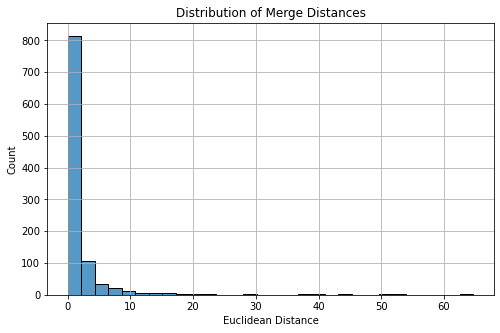

In [98]:
# Get distances
coph_dists = [i[2] for i in Z]

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(coph_dists, bins=30)
plt.title('Distribution of Merge Distances')
plt.xlabel('Euclidean Distance')
plt.grid(True)
plt.show()

These intermediate plots help remind me what is being calculated. This distribution shows that there were many short-distance merges and then a steep drop-off and few long-distance merges. This plot indicates that the calculation worked, but cannot indicate that the clusters are well fit.

The cophenetic correlation coefficient calculates the correlation between the merge distances and the pairwise distances.

In [122]:
# Calculate c
c, coph_dists = cophenet(Z, pdist(sc_params))
print(f'Cophenentic Coeff: {round(c, 5)}')

# Print Last 10 merge distances
print(f'Last 10 Merges: {Z[-10:,2]}')

Cophenentic Coeff: 0.42985
Last 10 Merges: [22.73601639 29.76609019 29.98886932 37.38609647 39.26524788 40.24168985
 45.06013172 51.53842946 53.01326516 64.6827849 ]


There is some correlation, but not strong correlation. There are probably some noticable clusters in the dendrogram. The distances of the last 3 merges (51.5, 53.0, 64.7) don't show huge jumps, so it might indicate that some points are not clearly separated.

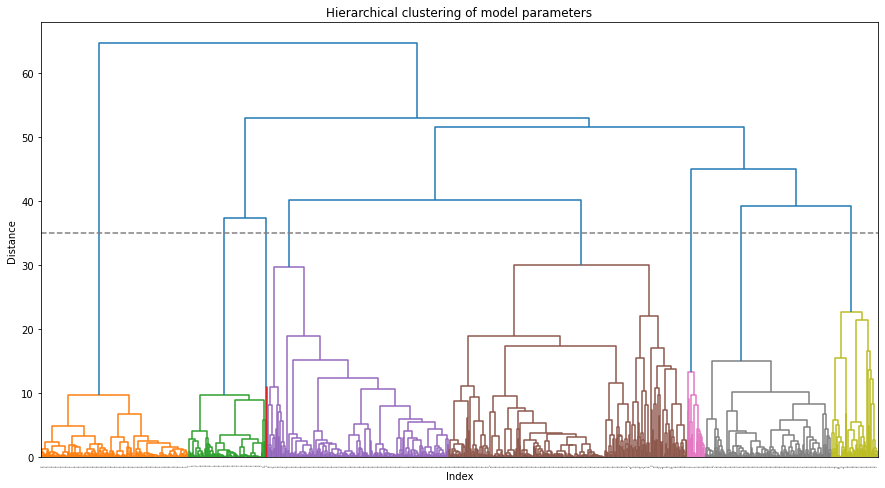

In [131]:
# Plot the Dendrogram
plt.figure(figsize=(15,8))
plt.title('Hierarchical clustering of model parameters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.tick_params(labelbottom = False)
dendrogram(Z, leaf_font_size=0, color_threshold=35)
plt.axhline(y=35, linestyle='dashed', color='grey')
plt.show()

Kind of messy, the purple and brown clusters seem to add more data with consistent distances. The color cutoff at 35 is where I would manually choose to segment the models and I would end up 8 hypothese to evaluate. Let's check if the *elbow* method will give any insight into how many clusters to include.

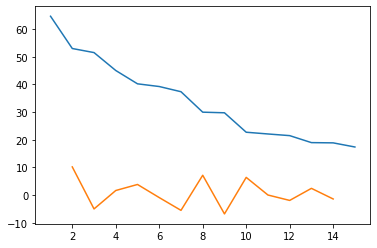

Clusters: 2


In [143]:
# Create merge indices
idxs = np.arange(1, len(Z[-15:,2]) + 1)
# Calculate merge length acceleration
acc = np.diff(Z[-15:,2][::-1], 2)
# Plot acceleration and merge lengths
plt.plot(idxs, Z[-15:,2][::-1])
plt.plot(idxs[:-2] + 1, acc)
plt.show()
# Print max acc
print(f'Clusters: {acc.argmax()+2}')

The maximum distance acceleration occured at the final step, which would segment the models into the orange cluster and everything else. There could be many reasons that the clusters were not well identified. I suspect that the higher dimensionality (14 parameters) and low observations cause the data to become sparse.